## Preprocces Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
import zipfile
import os

zip_path = "dataset.zip"
extract_path = ""

# Ensure the extract path exists

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(extract_path)

data = pd.read_csv("dataset.csv")  # Replace with your actual dataset file



In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data.shape

(50000, 2)

In [ ]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetical characters
    return text

data_reviews = data['review'].apply(preprocess_text)
example = data_reviews[10]
data_reviews.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [32]:
data_sentiment_labels = data['sentiment']
example_senitment = 1 if data_sentiment_labels[10] == 'positive' else 0
data_sentiment_labels.head()

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

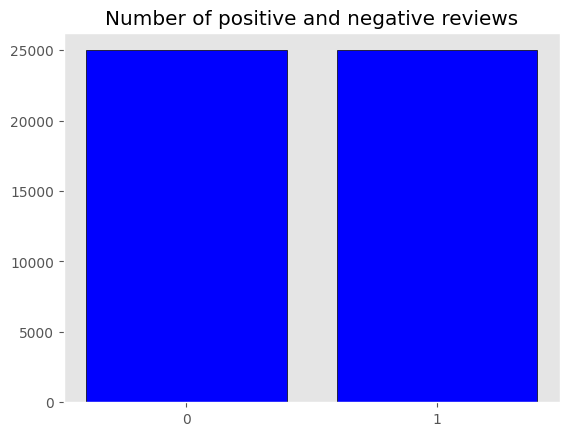

In [7]:
hist = [1 if sentiment == 'positive' else 0 for sentiment in data_sentiment_labels]
plt.hist(hist, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.8, color='blue')
plt.title("Number of positive and negative reviews")
plt.xticks([0, 1])
plt.grid(False)
plt.show()

In [8]:
tokens = nltk.word_tokenize(example)
tokens

['phil',
 'the',
 'alien',
 'is',
 'one',
 'of',
 'those',
 'quirky',
 'films',
 'where',
 'the',
 'humour',
 'is',
 'based',
 'around',
 'the',
 'oddness',
 'of',
 'everything',
 'rather',
 'than',
 'actual',
 'punchlinesat',
 'first',
 'it',
 'was',
 'very',
 'odd',
 'and',
 'pretty',
 'funny',
 'but',
 'as',
 'the',
 'movie',
 'progressed',
 'i',
 'didnt',
 'find',
 'the',
 'jokes',
 'or',
 'oddness',
 'funny',
 'anymoreits',
 'a',
 'low',
 'budget',
 'film',
 'thats',
 'never',
 'a',
 'problem',
 'in',
 'itself',
 'there',
 'were',
 'some',
 'pretty',
 'interesting',
 'characters',
 'but',
 'eventually',
 'i',
 'just',
 'lost',
 'interesti',
 'imagine',
 'this',
 'film',
 'would',
 'appeal',
 'to',
 'a',
 'stoner',
 'who',
 'is',
 'currently',
 'partakingfor',
 'something',
 'similar',
 'but',
 'better',
 'try',
 'brother',
 'from',
 'another',
 'planet']

In [9]:
import pprint
tagged = nltk.pos_tag(tokens)
pprint.pp(tagged)


[('phil', 'IN'),
 ('the', 'DT'),
 ('alien', 'NN'),
 ('is', 'VBZ'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('those', 'DT'),
 ('quirky', 'JJ'),
 ('films', 'NNS'),
 ('where', 'WRB'),
 ('the', 'DT'),
 ('humour', 'NN'),
 ('is', 'VBZ'),
 ('based', 'VBN'),
 ('around', 'IN'),
 ('the', 'DT'),
 ('oddness', 'NN'),
 ('of', 'IN'),
 ('everything', 'NN'),
 ('rather', 'RB'),
 ('than', 'IN'),
 ('actual', 'JJ'),
 ('punchlinesat', 'NN'),
 ('first', 'VBD'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('very', 'RB'),
 ('odd', 'JJ'),
 ('and', 'CC'),
 ('pretty', 'JJ'),
 ('funny', 'JJ'),
 ('but', 'CC'),
 ('as', 'IN'),
 ('the', 'DT'),
 ('movie', 'NN'),
 ('progressed', 'VBD'),
 ('i', 'JJ'),
 ('didnt', 'NN'),
 ('find', 'VBP'),
 ('the', 'DT'),
 ('jokes', 'NNS'),
 ('or', 'CC'),
 ('oddness', 'JJ'),
 ('funny', 'JJ'),
 ('anymoreits', 'NNS'),
 ('a', 'DT'),
 ('low', 'JJ'),
 ('budget', 'NN'),
 ('film', 'NN'),
 ('thats', 'NNS'),
 ('never', 'RB'),
 ('a', 'DT'),
 ('problem', 'NN'),
 ('in', 'IN'),
 ('itself', 'PRP'),
 ('there', 'EX'),
 ('we

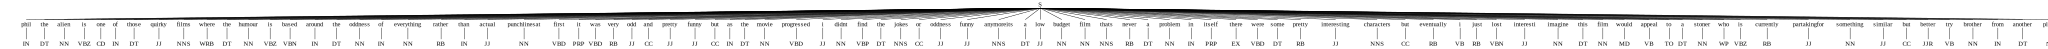

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities

## BERT Model

In [11]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm_notebook

In [12]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
TOKEN = f"cardiffnlp/twitter-roberta-base-sentiment"
CHECKPOINT_MODEL = f"test_trainer/checkpoint-12000"
MODEL_MAX_LENGTH = 128
def createTokenizerAndModel(MODEL):
    tokenizer = AutoTokenizer.from_pretrained(TOKEN)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    return tokenizer, model
tokenizer, model = createTokenizerAndModel(CHECKPOINT_MODEL)


In [13]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts (list of str): Lista tekstova.
            labels (list of int): Lista pripadajućih oznaka.
            tokenizer (callable): Tokenizer koji pretvara tekst u vektore.
            max_length (int): Maksimalna duljina sekvence.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
X = data_reviews
y = data_sentiment_labels.map({"positive": 1, "negative": 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2)


#### Fine tune BERT model

In [15]:
from transformers import TrainingArguments, Trainer
import evaluate
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")
metric = evaluate.load("accuracy")
trainDataset = TextDataset(X_train.values, y_train.values, tokenizer)
evalDataset = TextDataset(X_eval.values, y_eval.values, tokenizer)

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from torch.utils.data.dataset import Dataset

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainDataset,
    eval_dataset=evalDataset,
    compute_metrics=compute_metrics,
)
# trainer.train()

#### Compare to pretrained BERT model

In [18]:
def polarity_scores_roberta(model, example):
    encoded_text = tokenizer(example, return_tensors='pt', max_length=MODEL_MAX_LENGTH, truncation=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

_, pretrained_model = createTokenizerAndModel(MODEL)


In [19]:
testDataset = TextDataset(X_test.values, y_test.values, tokenizer)
model_predictions = trainer.predict(testDataset)
model_predictions[2]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'test_loss': 0.23613564670085907,
 'test_model_preparation_time': 0.0026,
 'test_accuracy': 0.9527,
 'test_runtime': 115.6796,
 'test_samples_per_second': 86.446,
 'test_steps_per_second': 10.806}

In [ ]:
res = {}
for index, text in enumerate(X_test):
    try:
        roberta_pretrained_result = polarity_scores_roberta(pretrained_model, text)
    
        res = {**roberta_pretrained_result}
    except RuntimeError:
        print(f'Broke for id {index}')

#### Izvest Usporedbu u accuracy 